In [1]:
import os
import sys
#
import tensorflow as tf
# limit gpu mem
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=3700)])
#
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose, GaussianNoise,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)
from tensorflow.keras.models import Sequential, Model
from time import time

import numpy as np
import cv2
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
#from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Conv2D
#
from matplotlib import pyplot
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img,save_img
#from keras.utils.vis_utils import plot_model
from copy import deepcopy

from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
from PIL import Image

convstride_enc=np.array([[[3,3],[1,1]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])
convstride_dec=np.array([[[3,3],[1,1]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])  
convstride_dis=np.array([[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])

2023-09-15 16:50:53.313285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 16:50:54.072713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-15 16:50:54.746225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 16:50:54.772900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

1 Physical GPUs, 1 Logical GPUs


In [2]:
# conversion lab & rgb
def lab_to_rgb(img_lab):
    img_lab = img_lab.numpy()
    L = (img_lab[:,:,:,0] + 1.) * 50. 
    L = L[..., np.newaxis]
    ab = img_lab[:,:,:,1:]  * 110
    img_lab = np.concatenate((L,ab),axis=3)
    #
    img = lab2rgb(img_lab).astype("float32")
    img = (img * 255).astype(np.uint8)
    return img

def rgb_to_lab(img):
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b    # float16 to optimize ?
    # Between -1 and 1
    L  = img_lab[:,:,0]  / 50. - 1. 
    ab = img_lab[:,:,1:]  / 110. # Between -1 and 1 
    return L, ab

**MODEL**

In [3]:
# define an encoder block
def define_encoder_block(layer_in,name, n_filters,kernel=(3,3),strides=(2,2), batchnorm=True, pad='same'):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # padding
        if (pad == 'valid'):
            layer_in = tf.pad(layer_in, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        # add downsampling layer
        g = Conv2D(n_filters, kernel, strides=strides, padding=pad, kernel_initializer=init,name=name)(layer_in)
        # conditionally add batch normalization
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        # leaky relu activation
        g = LeakyReLU(alpha=0.2)(g)
        return g

# define a decoder block
def decoder_block(layer_in, skip_in,name, n_filters,kernel=(3,3),strides=(2,2), dropout=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add upsampling layer
        g = Conv2DTranspose(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # add batch normalization
        g = BatchNormalization()(g, training=True)
        # conditionally add dropout
        if dropout:
            g = Dropout(0.3)(g, training=True)
        # merge with skip connection
        g = Concatenate()([g, skip_in])
        # relu activation
        g = Activation('relu')(g)
        return g

# define the standalone generator model
def define_generator(image_shape):   # input L : 480x640x1, output ab : 480x640x1 
        convstrideg=convstride_enc.copy()
        print(convstrideg.shape)
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e0 = define_encoder_block(in_image,"encoder_block_0", 64, kernel=conv,strides=stride, pad='valid') # 64  pad='valid'
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e1 = define_encoder_block(e0,"encoder_block_1", 128, kernel=conv,strides=stride) # 64
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e2 = define_encoder_block(e1,"encoder_block_2", 256,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e3 = define_encoder_block(e2,"encoder_block_3", 512,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e4 = define_encoder_block(e3,"encoder_block_4", 512,kernel=conv,strides=stride) # 16
        # bottleneck, no batch norm and relu
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        b = Conv2D(512, conv,strides=stride, padding='same', kernel_initializer=init,name="bottleneck_conv2d")(e4)
        b = Activation('relu')(b)
        # decoder model
        convstrideg=convstride_dec.copy()
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d4 = decoder_block(b, e4,"decoder_block_4", 512,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d5 = decoder_block(d4, e3,"decoder_block_3",512,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d6 = decoder_block(d5, e2,"decoder_block_2", 256,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d7 = decoder_block(d6, e1,"decoder_block_1", 128,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d8 = decoder_block(d7, e0,"decoder_block_0", 64,kernel=conv,strides=stride, dropout=False)
        # output
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        g = tf.pad(d8, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        g = Conv2D(3, conv,strides=stride, padding='valid',kernel_initializer=init, name="3rd_last_layer")(g)    
        out_image = Activation('tanh')(g)
        
        # define model
        model = Model(in_image, out_image)
        model.summary()
        return model


# define the discriminator model
def define_discriminator(image_shape):    # input concatenate(L,ab) : 480x640x3, output : 1,0
        convstrided=convstride_dis.copy()
        print(convstrided.shape)
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_src_image = Input(shape=image_shape)
        # C64
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(32, conv, strides=stride, padding='same', kernel_initializer=init)(in_src_image)
        #d = tf.keras.layers.GaussianNoise(stddev= 0.1)(d)
        d = Dropout(0.3)(d, training=True)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(64, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = Dropout(0.3)(d, training=True)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(128, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = Dropout(0.3)(d, training=True)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(256, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = Dropout(0.3)(d, training=True)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(512, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = Dropout(0.3)(d, training=True)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(1, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model(in_src_image, patch_out)
        model.summary()
        return model

**LOSS**

In [4]:
LAMBDA = 5
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.4 * loss

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def gan_loss(disc_generated_A):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_A), disc_generated_A)
    return gan_loss

def GEN_total_loss(GEN_X, GEN_Y, im_X, im_Y, gen_output_X_Y_bar, gen_output_Y_X_bar, disc_generated_X, disc_generated_Y ):
    id_X_loss = identity_loss(im_Y, GEN_X(im_Y))
    id_Y_loss = identity_loss(im_X, GEN_Y(im_X))
            
    cycle_X_loss= calc_cycle_loss(gen_output_Y_X_bar, im_X)
    cycle_Y_loss= calc_cycle_loss(gen_output_X_Y_bar, im_Y)
    cycle_total_loss = cycle_X_loss + cycle_Y_loss
            
    gan_X_loss = gan_loss(disc_generated_Y)
    gan_Y_loss = gan_loss(disc_generated_X)
    
    total_X = gan_X_loss + cycle_total_loss + id_X_loss
    total_Y = gan_Y_loss + cycle_total_loss + id_Y_loss
    
    return total_X, gan_X_loss, id_X_loss, total_Y, gan_Y_loss, id_Y_loss, cycle_total_loss
    
# old loss
def generator_loss(disc_generated_A, gen_output_A_B_bar, img_B):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_A), disc_generated_A)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(gen_output_A_B_bar - img_B))
    #
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [5]:
GEN_X = define_generator(image_shape=(256,256,3))
DISC_X = define_discriminator(image_shape=(256,256,3))

GEN_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
DISC_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

GEN_Y = define_generator(image_shape=(256,256,3))
DISC_Y = define_discriminator(image_shape=(256,256,3))

GEN_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
DISC_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

(6, 2, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.pad (TFOpLamb  (None, 258, 258, 3)          0         ['input_1[0][0]']             
 da)                                                                                              
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 256, 256, 64)         1792      ['tf.compat.v1.pad[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['encoder_block_

                                                                                                  
 decoder_block_1 (Conv2DTra  (None, 128, 128, 128)        589952    ['activation_3[0][0]']        
 nspose)                                                                                          
                                                                                                  
 batch_normalization_8 (Bat  (None, 128, 128, 128)        512       ['decoder_block_1[0][0]']     
 chNormalization)                                                                                 
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 256)        0         ['batch_normalization_8[0][0]'
 )                                                                  , 'leaky_re_lu_1[0][0]']      
                                                                                                  
 activatio

/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(6, 2, 2)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)  

                                                                    ']                            
                                                                                                  
 bottleneck_conv2d (Conv2D)  (None, 8, 8, 512)            2359808   ['leaky_re_lu_14[0][0]']      
                                                                                                  
 activation_8 (Activation)   (None, 8, 8, 512)            0         ['bottleneck_conv2d[0][0]']   
                                                                                                  
 decoder_block_4 (Conv2DTra  (None, 16, 16, 512)          2359808   ['activation_8[0][0]']        
 nspose)                                                                                          
                                                                                                  
 batch_normalization_19 (Ba  (None, 16, 16, 512)          2048      ['decoder_block_4[0][0]']     
 tchNormal

                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_24 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_25 (Ba  (None, 32, 32, 128)       512       
 tchNormal

**UTILS**

In [6]:
# plot real source images
def summarize_performance(step, img_X_B, img_X_Y, img_Y_B, img_Y_X):
    X_B = (img_X_B[-1] +1.0) / 2.0   # -1
    X_Y = (img_X_Y[0] +1.0 ) / 2.0   
    Y_B = (img_Y_B[-1] +1.0) / 2.0   # -1
    Y_X = (img_Y_X[0] + 1.0) / 2.0

    pyplot.subplot(2, 2, 1)
    pyplot.axis('off')       
    pyplot.imshow(X_B)
    pyplot.title('X org')
    
    pyplot.subplot(2, 2, 2)
    pyplot.axis('off')       
    pyplot.imshow(X_Y) 
    pyplot.title('X org -> Y')

    pyplot.subplot(2, 2, 3)
    pyplot.axis('off')       
    pyplot.imshow(Y_B)  #*255   
    pyplot.title('Y org')

    pyplot.subplot(2, 2, 4)
    pyplot.axis('off')       
    pyplot.imshow(Y_X) 
    pyplot.title('Y org -> X')

    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

def test_loss_avg(GEN_X, DISC_Y,path):
    Loss_avg = list()
    #L1_avg = list()

    IMAGE=os.listdir(path)
    IMAGE.sort()
    
    for file_img in IMAGE:
        print(file_img)
        new_im = os.path.join(path,file_img)

        # now read the input image files (difference from the code it is derived from that preloads all images)
        pixels = Image.open(new_im).convert("RGB")
        pixels = np.array(pixels)
        pixels = pixels[np.newaxis, ...]
        #
        img_Y_fake = GEN_X(pixels, training=False)
        #
        disc_on_test = DISC_Y(img_Y_fake,training=False)
        #
        test_loss = gan_loss(disc_on_test)
        #test_loss, gan_loss, l1_loss=generator_loss(disc_on_test, img_Y_fake, pixels)
        Loss_avg.append(test_loss)
        #L1_avg.append(l1_loss)
        
    avg = np.mean(Loss_avg) 
    #l1 = np.mean(L1_avg)
    return avg

def shuffle_and_batch(Dataset, buff_size, SEED):
    # SHUFFLE
    Dataset_S = Dataset.shuffle(buffer_size = buff_size,seed=SEED)    #10 * BATCH_SIZE   L_dataset.cardinality()
    # Batch
    Dataset_B = Dataset_S.batch(BATCH_SIZE)
    return(Dataset_B)

def change_Bright(image,B):        #run_eagerly=True   ???
    img = rgb2hsv(image[0:1]*127.5 + 127.5)
    img[:,:,:,2] = np.clip(img[:,:,:,2]*B,0,255)
    img = (hsv2rgb(img) - 127.5) / 127.5
    img_final = tf.keras.layers.concatenate([img, image[1:]],axis=0)
    return img_final

In [7]:
# GEN_X -->  Generator from X to Y
# DISC_X --> Discriminator of X images
# ...

@tf.function
def train_step(GEN_X, DISC_X, GEN_Y, DISC_Y, img_X, img_Y, batch):  
    GLX=DLX= tf.constant(0.)
    GLY=DLY= tf.constant(0.)
    GANX=GANY=tf.constant(0.)
    IDX=IDY= tf.constant(0.)
    CYCLE =  tf.constant(0.)
    # for each image of the batch
    with tf.GradientTape() as genX_tape, tf.GradientTape() as discX_tape, tf.GradientTape() as genY_tape, tf.GradientTape() as discY_tape:
        for i in range(batch):
            #  X --> Y --> X_bar  #
            gen_output_X_Y = GEN_X(img_X[i:i+1], training=True)
            gen_output_Y_X_bar = GEN_Y(gen_output_X_Y, training=True)
            #  Y --> X --> Y_bar  #
            gen_output_Y_X = GEN_Y(img_Y[i:i+1], training=True)
            gen_output_X_Y_bar = GEN_X(gen_output_Y_X, training=True)
            #
            #  DISCRIMINATOR generated losses  #
            disc_generated_X = DISC_X(gen_output_Y_X , training=True)
            disc_generated_Y = DISC_Y(gen_output_X_Y, training=True)
            #  DISCRIMINATOR Real losses  #
            disc_real_X = DISC_X(img_X[i:i+1], training=True)
            disc_real_Y = DISC_Y(img_Y[i:i+1], training=True)
            #  DISCRIMINATOR total losses  #
            disc_loss_X = discriminator_loss(disc_real_X, disc_generated_X)
            disc_loss_Y = discriminator_loss(disc_real_Y, disc_generated_Y)
            #
            TOTAL_X, gan_X_loss, id_X_loss, TOTAL_Y, gan_Y_loss, id_Y_loss, CYCLE_loss = GEN_total_loss(GEN_X, GEN_Y, img_X[i:i+1], img_Y[i:i+1], gen_output_X_Y_bar, gen_output_Y_X_bar, disc_generated_X, disc_generated_Y)
            #
            DLX=tf.add(DLX,disc_loss_X)
            GLX=tf.add(GLX,TOTAL_X)
            DLY=tf.add(DLY,disc_loss_Y)
            GLY=tf.add(GLY,TOTAL_Y)
            #
            GANX = tf.add(GANX, gan_X_loss)
            IDX = tf.add(IDX, id_X_loss)
            GANY = tf.add(GANX, gan_X_loss)
            IDY = tf.add(IDX, id_X_loss)
            CYCLE = tf.add(CYCLE, CYCLE_loss)
            
        # mean of batch loss
        DLX = tf.math.divide(DLX,batch)
        GLX = tf.math.divide(GLX,batch)
        DLY = tf.math.divide(DLY,batch)
        GLY = tf.math.divide(GLY,batch)
        GANX= tf.math.divide(GANX,batch)
        IDX = tf.math.divide(IDX,batch)
        GANY= tf.math.divide(GANY,batch)
        IDY = tf.math.divide(IDY,batch)
        CYCLE=tf.math.divide(CYCLE,batch)
        
        # Update at the end of batch
        generator_gradients_X = genX_tape.gradient(GLX,
                                                GEN_X.trainable_variables)
        discriminator_gradients_X = discX_tape.gradient(DLX,
                                                     DISC_X.trainable_variables)
        GEN_X_optimizer.apply_gradients(zip(generator_gradients_X,
                                              GEN_X.trainable_variables))
        DISC_X_optimizer.apply_gradients(zip(discriminator_gradients_X,
                                                  DISC_X.trainable_variables))
        
        generator_gradients_Y = genY_tape.gradient(GLY,
                                                GEN_Y.trainable_variables)
        discriminator_gradients_Y = discY_tape.gradient(DLY,
                                                     DISC_Y.trainable_variables)
        GEN_Y_optimizer.apply_gradients(zip(generator_gradients_Y,
                                              GEN_Y.trainable_variables))
        DISC_Y_optimizer.apply_gradients(zip(discriminator_gradients_Y,
                                                  DISC_Y.trainable_variables))

    return GLX, DLX, GLY, DLY, gen_output_X_Y, gen_output_Y_X, GANX, IDX, GANY, IDY, CYCLE


# train pix2pix models
def train(GEN_X, DISC_X, GEN_Y, DISC_Y, dataset, batch=4):
    # determine the output square shape of the discriminator
    n_patch1 = DISC_X.output_shape[1]
    n_patch2 = DISC_X.output_shape[2]
    # calculate the number of batches per training epoch
    #
    GLoss = []
    DLoss = []
    GanX = []
    GanY= []
    IdX= []
    IdY= []
    Cycle= []
    #
    i=0
    # manually enumerate batch
    for data in dataset:
        img_X = data[:,:,:,:3]
        img_Y = data[:,:,:,3:]
        # BRIGHT +/-
        bright = np.clip(np.random.normal(0.9,0.2),0.8,1.1)  # (0.9,0.2),0.8,1.1)    (0.8,0.25),0.7,1.2) 
        img_X_B = change_Bright(img_X,bright)
        img_Y_B = change_Bright(img_Y,bright)
        # train step, update loss, gradient
        gen_loss_X, disc_loss_X, gen_loss_Y, disc_loss_Y, img_X_Y, img_Y_X, GANX, IDX, GANY, IDY, CYCLE = train_step(GEN_X, DISC_X, GEN_Y, DISC_Y, img_X_B, img_Y_B, batch)    # tf.constant()
        #
        print("step "+str(i)+" gen_loss : "+str(gen_loss_X.numpy())+" disc_loss : "+str(disc_loss_X.numpy())+" Bright coef : "+str(bright))
        GLoss.append(gen_loss_X.numpy())
        DLoss.append(disc_loss_X.numpy())
        GanX.append(GANX.numpy())
        GanY.append(GANY.numpy())
        IdX.append(IDX.numpy())
        IdY.append(IDY.numpy())
        Cycle.append(CYCLE.numpy())
        # summarize model performance every 200 steps
        if (i % 20 == 0) and (i !=0):
            summarize_performance(i, img_X_B, img_X_Y, img_Y_B, img_Y_X)
        i+=1
    return(DLoss, GLoss, GEN_X, DISC_X, GEN_Y, DISC_Y, GanX, GanY, IdX, IdY, Cycle)


Learning Rate G : 0.0002 Learning Rate D : 5e-05
Seed :  5546

Start of epoch 1


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4040241663323905875
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4040241663323905875
2023-09-15 16:51:15.602034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: 

step 0 gen_loss : 9.782321 disc_loss : 1.3685415 Bright coef : 0.8
step 1 gen_loss : 5.9297886 disc_loss : 1.6699625 Bright coef : 0.8
step 2 gen_loss : 6.9315243 disc_loss : 1.8194358 Bright coef : 0.8
step 3 gen_loss : 4.9911094 disc_loss : 1.5699823 Bright coef : 0.8
step 4 gen_loss : 5.3501034 disc_loss : 1.7092617 Bright coef : 0.9699763613557568
step 5 gen_loss : 4.6062536 disc_loss : 1.5528995 Bright coef : 0.8
step 6 gen_loss : 4.5520453 disc_loss : 1.424107 Bright coef : 1.0361837352927634
step 7 gen_loss : 3.680949 disc_loss : 1.5728192 Bright coef : 0.9367371723803376
step 8 gen_loss : 3.6534543 disc_loss : 1.592746 Bright coef : 0.8398002022338954
step 9 gen_loss : 4.4697514 disc_loss : 1.4450114 Bright coef : 0.9228824494151759
step 10 gen_loss : 3.1076367 disc_loss : 1.8102771 Bright coef : 0.850819299476317
step 11 gen_loss : 4.5911293 disc_loss : 1.6232517 Bright coef : 1.1
step 12 gen_loss : 2.9665954 disc_loss : 1.3038936 Bright coef : 0.8
step 13 gen_loss : 4.296647 

step 107 gen_loss : 2.632405 disc_loss : 1.3248172 Bright coef : 0.8
step 108 gen_loss : 2.043913 disc_loss : 1.5876848 Bright coef : 0.8715133519559211
step 109 gen_loss : 2.4129841 disc_loss : 1.3496885 Bright coef : 1.040002422376771
step 110 gen_loss : 2.2081904 disc_loss : 1.4154974 Bright coef : 0.8070873563282246
step 111 gen_loss : 2.7592888 disc_loss : 1.6230657 Bright coef : 0.8
step 112 gen_loss : 3.8552642 disc_loss : 1.6402551 Bright coef : 0.9701688484951179
step 113 gen_loss : 2.671222 disc_loss : 1.158968 Bright coef : 1.1
step 114 gen_loss : 2.1790655 disc_loss : 1.4492416 Bright coef : 0.9718171091560759
step 115 gen_loss : 4.090476 disc_loss : 1.2964315 Bright coef : 0.8814758441673977
step 116 gen_loss : 4.449248 disc_loss : 1.4945002 Bright coef : 1.1
step 117 gen_loss : 2.3910494 disc_loss : 1.5629102 Bright coef : 0.9257950576430789
step 118 gen_loss : 2.6738987 disc_loss : 1.6614541 Bright coef : 1.1
step 119 gen_loss : 2.6270068 disc_loss : 1.5405724 Bright coe

step 213 gen_loss : 3.4811795 disc_loss : 1.6228018 Bright coef : 0.93188247253411
step 214 gen_loss : 3.7418454 disc_loss : 1.741698 Bright coef : 0.839047294286078
step 215 gen_loss : 2.8894827 disc_loss : 1.494499 Bright coef : 0.9023966118214836
step 216 gen_loss : 2.9276536 disc_loss : 1.5427617 Bright coef : 0.9784845629192311
step 217 gen_loss : 3.0332177 disc_loss : 1.4683995 Bright coef : 1.0431537506064439
step 218 gen_loss : 2.9751108 disc_loss : 1.2064161 Bright coef : 0.9151179055812522
step 219 gen_loss : 2.1796877 disc_loss : 1.44349 Bright coef : 0.8324993694035441
step 220 gen_loss : 3.131941 disc_loss : 1.3805722 Bright coef : 1.1
step 221 gen_loss : 3.431117 disc_loss : 1.4636732 Bright coef : 0.8
step 222 gen_loss : 2.2607725 disc_loss : 1.7192321 Bright coef : 1.1
step 223 gen_loss : 2.3127184 disc_loss : 1.0611748 Bright coef : 1.1
step 224 gen_loss : 2.7204294 disc_loss : 1.2843673 Bright coef : 1.1
step 225 gen_loss : 2.3738658 disc_loss : 1.6562624 Bright coef 

step 319 gen_loss : 2.4470851 disc_loss : 1.3738495 Bright coef : 1.0291958406341444
step 320 gen_loss : 2.9629843 disc_loss : 1.5365126 Bright coef : 0.8
step 321 gen_loss : 2.454807 disc_loss : 1.5812702 Bright coef : 0.9179153993614526
step 322 gen_loss : 2.3984349 disc_loss : 1.6552308 Bright coef : 0.8553578138908272
step 323 gen_loss : 2.7824106 disc_loss : 1.6350055 Bright coef : 1.1
step 324 gen_loss : 2.5022657 disc_loss : 1.8923466 Bright coef : 1.1
step 325 gen_loss : 2.069081 disc_loss : 1.242878 Bright coef : 0.968294514577636
step 326 gen_loss : 2.1392658 disc_loss : 1.6651863 Bright coef : 0.8
step 327 gen_loss : 2.4389758 disc_loss : 1.6739607 Bright coef : 0.8
step 328 gen_loss : 2.1895237 disc_loss : 1.3445417 Bright coef : 0.8
step 329 gen_loss : 3.4101682 disc_loss : 1.4649711 Bright coef : 1.1
step 330 gen_loss : 2.8823528 disc_loss : 1.6980687 Bright coef : 1.0773350247783053
step 331 gen_loss : 3.153538 disc_loss : 1.6524962 Bright coef : 1.06609258556247
step 33

step 424 gen_loss : 2.329239 disc_loss : 1.5348519 Bright coef : 0.8
step 425 gen_loss : 3.2961576 disc_loss : 1.3846605 Bright coef : 1.1
step 426 gen_loss : 3.3715668 disc_loss : 1.5187633 Bright coef : 1.1
step 427 gen_loss : 2.963901 disc_loss : 1.3846856 Bright coef : 0.8399413041320759
step 428 gen_loss : 2.5489798 disc_loss : 1.430404 Bright coef : 0.8
step 429 gen_loss : 2.1642387 disc_loss : 1.7608416 Bright coef : 0.8
step 430 gen_loss : 2.352018 disc_loss : 1.8088486 Bright coef : 0.8649399701226085
step 431 gen_loss : 3.2896643 disc_loss : 2.0972762 Bright coef : 1.1
step 432 gen_loss : 2.935738 disc_loss : 1.6077318 Bright coef : 1.1
step 433 gen_loss : 2.3114133 disc_loss : 1.4543335 Bright coef : 0.9075059029888585
step 434 gen_loss : 1.814586 disc_loss : 1.4874501 Bright coef : 0.8742206873517804
step 435 gen_loss : 2.5432487 disc_loss : 1.4183813 Bright coef : 0.9055620673522242
step 436 gen_loss : 2.9288654 disc_loss : 1.6495602 Bright coef : 1.0664578093464596
step 4

image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
image_00000134-3.png
image_00000135-3.png
image_00000138-3.png
image_00000139-3.png
image_00000147-3.png
image_00000148-3.png
X :  [1]
G :  [3.0222337]
D :  [1.5251389]
T_avg :  [0.7182927]


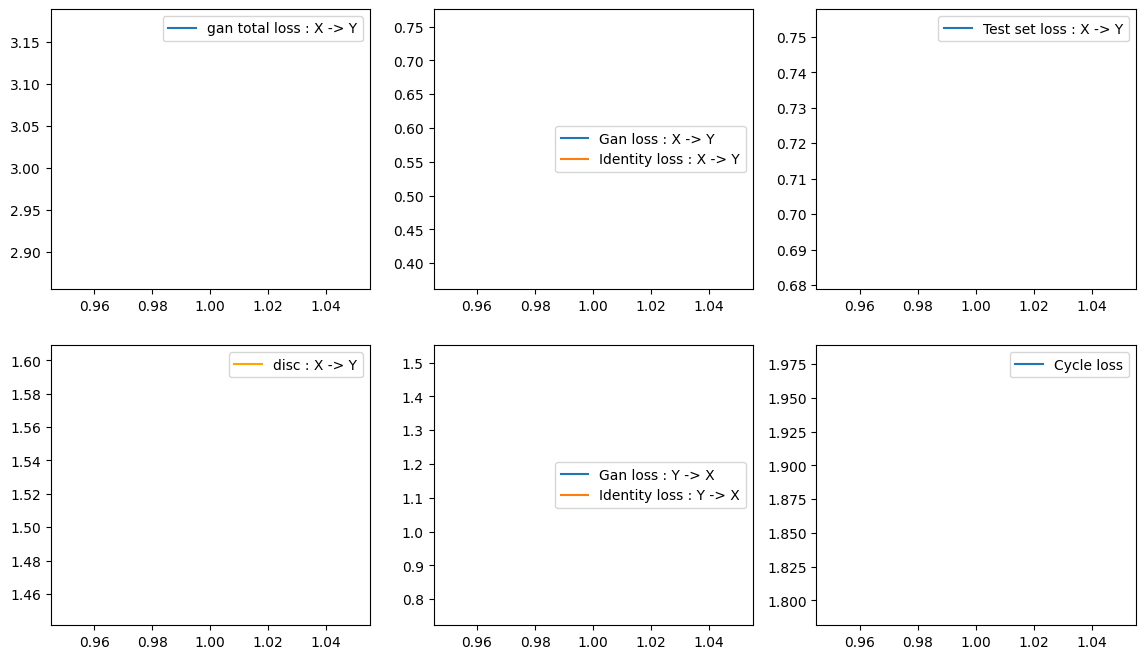

Seed :  5848

Start of epoch 2


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4040241663323905875


step 0 gen_loss : 2.9491725 disc_loss : 1.3831406 Bright coef : 1.0587693022666198
step 1 gen_loss : 2.2093098 disc_loss : 1.535143 Bright coef : 0.8689617695098424
step 2 gen_loss : 4.1197677 disc_loss : 1.7146344 Bright coef : 0.8
step 3 gen_loss : 3.993009 disc_loss : 1.4055902 Bright coef : 0.8
step 4 gen_loss : 2.3628333 disc_loss : 1.680497 Bright coef : 0.8
step 5 gen_loss : 3.0850148 disc_loss : 1.3897853 Bright coef : 0.9627067462785022
step 6 gen_loss : 2.1749895 disc_loss : 1.3520195 Bright coef : 0.8
step 7 gen_loss : 2.373806 disc_loss : 1.5326481 Bright coef : 0.8396101120999135
step 8 gen_loss : 3.4394953 disc_loss : 1.4737265 Bright coef : 0.9483525271688995
step 9 gen_loss : 3.602229 disc_loss : 1.7736237 Bright coef : 0.9632299446206054
step 10 gen_loss : 1.777467 disc_loss : 1.8351221 Bright coef : 0.8
step 11 gen_loss : 3.4508572 disc_loss : 1.2234412 Bright coef : 0.8075338977422939
step 12 gen_loss : 5.009096 disc_loss : 1.2732877 Bright coef : 1.1
step 13 gen_los

step 108 gen_loss : 2.758548 disc_loss : 1.3434111 Bright coef : 0.8
step 109 gen_loss : 1.8769475 disc_loss : 1.7717218 Bright coef : 0.9241841559492932
step 110 gen_loss : 2.666643 disc_loss : 1.4202849 Bright coef : 0.9185179163697358
step 111 gen_loss : 2.6797526 disc_loss : 1.6641606 Bright coef : 0.9915939288202404
step 112 gen_loss : 3.2538428 disc_loss : 1.3533462 Bright coef : 0.8
step 113 gen_loss : 2.4061189 disc_loss : 1.6967955 Bright coef : 0.9596292196178903
step 114 gen_loss : 4.3034973 disc_loss : 1.315993 Bright coef : 1.1
step 115 gen_loss : 1.6253263 disc_loss : 1.8085537 Bright coef : 0.9462299456552004
step 116 gen_loss : 2.8872902 disc_loss : 1.3319111 Bright coef : 0.8
step 117 gen_loss : 2.02601 disc_loss : 1.4069209 Bright coef : 0.8118914799324181
step 118 gen_loss : 2.7609882 disc_loss : 1.8863955 Bright coef : 0.8
step 119 gen_loss : 3.94405 disc_loss : 1.3446858 Bright coef : 1.068415685595328
step 120 gen_loss : 2.0771797 disc_loss : 1.4594576 Bright coef

step 215 gen_loss : 2.6966875 disc_loss : 1.5262513 Bright coef : 0.8
step 216 gen_loss : 4.4350934 disc_loss : 1.3638651 Bright coef : 1.1
step 217 gen_loss : 3.4334047 disc_loss : 1.5169002 Bright coef : 1.1
step 218 gen_loss : 2.2381585 disc_loss : 1.5593272 Bright coef : 0.9728606195131189
step 219 gen_loss : 3.1498036 disc_loss : 1.2882376 Bright coef : 0.8615795603553673
step 220 gen_loss : 3.0472987 disc_loss : 1.1695355 Bright coef : 1.1
step 221 gen_loss : 3.4376216 disc_loss : 1.4737071 Bright coef : 0.8
step 222 gen_loss : 3.2764366 disc_loss : 1.7835598 Bright coef : 1.0932658734218774
step 223 gen_loss : 3.357698 disc_loss : 1.6421887 Bright coef : 0.8
step 224 gen_loss : 1.8211514 disc_loss : 1.2991786 Bright coef : 0.9438684231341818
step 225 gen_loss : 2.4867985 disc_loss : 1.3821254 Bright coef : 1.1
step 226 gen_loss : 3.9022539 disc_loss : 1.6041498 Bright coef : 1.1
step 227 gen_loss : 2.5763419 disc_loss : 1.807657 Bright coef : 0.8
step 228 gen_loss : 2.35437 disc

step 322 gen_loss : 2.4306974 disc_loss : 1.5945268 Bright coef : 0.9937939706800487
step 323 gen_loss : 2.8601208 disc_loss : 0.9363719 Bright coef : 1.1
step 324 gen_loss : 2.7500231 disc_loss : 1.2261808 Bright coef : 0.9915304494063069
step 325 gen_loss : 2.3237534 disc_loss : 1.527226 Bright coef : 0.8
step 326 gen_loss : 2.3543108 disc_loss : 1.3239872 Bright coef : 1.1
step 327 gen_loss : 2.2856803 disc_loss : 1.4581745 Bright coef : 1.041988210395898
step 328 gen_loss : 2.9660494 disc_loss : 1.7128816 Bright coef : 1.1
step 329 gen_loss : 2.1465485 disc_loss : 1.5395007 Bright coef : 1.1
step 330 gen_loss : 2.4571924 disc_loss : 1.4575523 Bright coef : 0.879476675095967
step 331 gen_loss : 2.5398555 disc_loss : 1.8145579 Bright coef : 0.80627471697812
step 332 gen_loss : 3.3881993 disc_loss : 1.4526031 Bright coef : 1.0343841938195057
step 333 gen_loss : 2.8737411 disc_loss : 1.193435 Bright coef : 0.8
step 334 gen_loss : 2.3256195 disc_loss : 1.5581378 Bright coef : 0.8
step 3

step 428 gen_loss : 2.2964268 disc_loss : 1.7216035 Bright coef : 0.9123044557254385
step 429 gen_loss : 4.246685 disc_loss : 1.3544083 Bright coef : 0.961838930969243
step 430 gen_loss : 2.3107448 disc_loss : 1.1750262 Bright coef : 1.1
step 431 gen_loss : 1.8660212 disc_loss : 1.6423205 Bright coef : 0.8
step 432 gen_loss : 2.241048 disc_loss : 1.562448 Bright coef : 0.8028476990179011
step 433 gen_loss : 2.551671 disc_loss : 1.5326321 Bright coef : 0.8
step 434 gen_loss : 2.9734676 disc_loss : 1.3548619 Bright coef : 0.8
step 435 gen_loss : 2.276128 disc_loss : 1.8127162 Bright coef : 0.8
step 436 gen_loss : 2.8739839 disc_loss : 1.1983607 Bright coef : 0.8
step 437 gen_loss : 4.489882 disc_loss : 1.1917069 Bright coef : 1.1


KeyboardInterrupt: 

In [8]:
# Test Path
path_test = 'test/test_set/test_set_Urban_Launcher_256'
# Save path
save_model = 'save_models/V_Urban_Launcher_Unet/V6_256_disc_downsize/'
save_loss = 'loss/loss_V_Urban_Launcher_Unet/V6_256_disc_downsize/'
#load
#generator.load_weights(save_model+'gen_model_color_epoch_5.h5')
#discriminator.load_weights(save_model+'dis_model_color_epoch_5.h5')

EPOCHS_START=1
EPOCHS = 50
BATCH_SIZE=1
LR_G = 2e-4
LR_D = 5e-5
print("Learning Rate G : "+str(LR_G)+" Learning Rate D : "+str(LR_D))
GEN_X_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)    #2e-4
DISC_X_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)  #2e-4

GEN_Y_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)    #2e-4
DISC_Y_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)  #2e-4
#
# Load dataset 
Dataset = tf.data.Dataset.load('./Dataset_wo_sky_256/V_Urban_Launcher/Dataset_VUL')
#
if EPOCHS_START!=1:
    #load loss
    GLoss_Epochs = list(np.load(save_loss+'Gloss_mean_5.npy')[0:EPOCHS_START])
    DLoss_Epochs = list(np.load(save_loss+'Dloss_mean_5.npy')[0:EPOCHS_START])
    TLoss_Epochs = list(np.load(save_loss+'Tloss_mean_5.npy')[0:EPOCHS_START])
else:
    GLoss_Epochs=[]
    DLoss_Epochs=[]
    TLoss_Epochs=[]
    GANXLoss_Epochs=[]
    GANYLoss_Epochs=[]
    IDXLoss_Epochs=[]
    IDYLoss_Epochs=[]
    CYCLELoss_Epochs=[]
#
for i in range(EPOCHS_START,EPOCHS+1):
    #
    SEED = random.randint(0,10000)
    print('Seed : ',SEED)
    # SHUFFLE AND BATCH
    Dataset_B = shuffle_and_batch(Dataset, 50, SEED)
    #
    #for j,L in enumerate(Dataset_B):
    #    print('dataset_'+str(j)+' saved', tf.shape(L))
    #print(j)
    print("\nStart of epoch %d" % (i,))
    #
    # train model
    (D,G, GEN_X, DISC_X, GEN_Y, DISC_Y, GanX, GanY, IdX, IdY, Cycle)=train(GEN_X, DISC_X, GEN_Y, DISC_Y, Dataset_B, batch=BATCH_SIZE)
    
    GLoss_Epochs.append(np.mean(G))
    DLoss_Epochs.append(np.mean(D))
    GANXLoss_Epochs.append(np.mean(GanX))
    GANYLoss_Epochs.append(np.mean(GanY))
    IDXLoss_Epochs.append(np.mean(IdX))
    IDYLoss_Epochs.append(np.mean(IdY))
    CYCLELoss_Epochs.append(np.mean(Cycle))
    
    DISC_X.save_weights(save_model+'disX_model_color_epoch_'+str(i)+'.h5')
    GEN_X.save_weights(save_model+'genX_model_color_epoch_'+str(i)+'.h5')
    DISC_Y.save_weights(save_model+'disY_model_color_epoch_'+str(i)+'.h5')
    GEN_Y.save_weights(save_model+'genY_model_color_epoch_'+str(i)+'.h5')
        
    # test loss
    AVG = test_loss_avg(GEN_X,DISC_Y,path_test)
    TLoss_Epochs.append(AVG)
    # Save loss
    np.save(save_loss+'Dloss_mean_'+str(i)+'.npy',DLoss_Epochs)
    np.save(save_loss+'Gloss_mean_'+str(i)+'.npy',GLoss_Epochs)
    np.save(save_loss+'Tloss_mean_'+str(i)+'.npy',TLoss_Epochs)
    
    X_EPOCHS = np.arange(1,i+1, 1)
    
    print('X : ',X_EPOCHS)
    print('G : ',GLoss_Epochs)
    print('D : ',DLoss_Epochs)
    print('T_avg : ',TLoss_Epochs)

    plt.figure(figsize=(14,8))
    plt.subplot(2, 3, 1)
    plt.plot(X_EPOCHS, GLoss_Epochs, label='gan total loss : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 2)
    plt.plot(X_EPOCHS, GANXLoss_Epochs, label='Gan loss : X -> Y')
    plt.plot(X_EPOCHS, IDXLoss_Epochs, label='Identity loss : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 3)
    plt.plot(X_EPOCHS, np.array(TLoss_Epochs), label='Test set loss : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 4)
    plt.plot(X_EPOCHS, DLoss_Epochs,'orange', label='disc : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 5)
    plt.plot(X_EPOCHS, GANYLoss_Epochs, label='Gan loss : Y -> X')
    plt.plot(X_EPOCHS, IDYLoss_Epochs, label='Identity loss : Y -> X')    
    plt.legend()
    plt.subplot(2, 3, 6)
    plt.plot(X_EPOCHS,CYCLELoss_Epochs, label='Cycle loss')
    plt.legend()
    #
    if (i%5 == 0):
        plt.savefig(save_loss+'Loss_'+str(i)+'.png')
        print('Saved')   
    plt.show()             

# save models
print("gan_model")

In [16]:
# try on a test image
import cv2
from tensorflow import keras
import numpy as np

save_models = 'save_models/V_Urban_Launcher_Unet/V5_256/'
image_shape=(1024,1024,3)

num = 12

# define the models
generator = define_generator(image_shape)
#load initial weights
generator.load_weights(save_models+'genX_model_color_epoch_'+str(num)+'.h5') #4,5,13,25

doss_image = 'test/val_set/org_1024'
doss_gen = 'test/val_set/V_Urban_Launcher_Unet/V5/V5/gen_'+str(num)  #V17/gen_50'
#doss_image ='dataset_color_transfer/test_sans_batch/V5_dts/new'
#doss_gen = 'dataset_color_transfer/test_sans_batch/V5_dts/old'

IMAGE=os.listdir(doss_image)
IMAGE.sort()

for file in IMAGE:
    old = os.path.join(doss_image,file)
    new = os.path.join(doss_gen,file+'_CGAN_'+str(num)+'.jpg') 
    #new = os.path.join(doss_gen,file) 
    X1=[]
    # now read the input image files (difference from the code it is derived from that preloads all images)
    pixels = Image.open(old).convert("RGB")
    pixels = np.array(pixels)
    pixels = pixels[np.newaxis, ...]
    #
    img_fake = generator(pixels, training=False)
    #print(tf.shape(img_fake))
    img_fake = img_fake[0].numpy() * 127.5 + 127.5
    img_fake= img_fake.astype(np.uint8)
    print(img_fake)
    image_reco=Image.fromarray(img_fake)
    #image_reco.show()
    #cv2.imwrite('test/image_00000168_gan_color.png',img.astype(int))
    image_reco = image_reco.save(new)

(6, 2, 2)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 tf.compat.v1.pad_36 (TFOpL  (None, 1026, 1026, 3)        0         ['input_12[0][0]']            
 ambda)                                                                                           
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 1024, 1024, 32)       896       ['tf.compat.v1.pad_36[0][0]'] 
                                                                                                  
 batch_normalization_98 (Ba  (None, 1024, 1024, 32)       128       ['encoder_blo

 nate)                                                              ]',                           
                                                                     'leaky_re_lu_57[0][0]']      
                                                                                                  
 activation_68 (Activation)  (None, 256, 256, 256)        0         ['concatenate_31727[0][0]']   
                                                                                                  
 decoder_block_1 (Conv2DTra  (None, 512, 512, 64)         147520    ['activation_68[0][0]']       
 nspose)                                                                                          
                                                                                                  
 batch_normalization_106 (B  (None, 512, 512, 64)         256       ['decoder_block_1[0][0]']     
 atchNormalization)                                                                               
          

[[[230 247 252]
  [232 248 252]
  [234 248 252]
  ...
  [234 248 253]
  [232 247 252]
  [233 249 253]]

 [[231 248 252]
  [235 249 252]
  [234 248 252]
  ...
  [235 249 252]
  [232 247 252]
  [234 249 252]]

 [[231 247 252]
  [234 249 252]
  [236 248 252]
  ...
  [240 250 253]
  [236 248 252]
  [237 249 252]]

 ...

 [[170 136 110]
  [180 153 126]
  [185 163 141]
  ...
  [213 184 164]
  [215 187 171]
  [210 182 161]]

 [[167 131 109]
  [178 150 121]
  [184 160 141]
  ...
  [208 182 157]
  [217 187 167]
  [209 184 156]]

 [[160 130  98]
  [172 140 110]
  [174 153 124]
  ...
  [213 189 158]
  [220 195 171]
  [214 190 159]]]
[[[146 227 247]
  [149 230 248]
  [148 226 247]
  ...
  [238 237 240]
  [237 233 237]
  [236 233 235]]

 [[146 229 248]
  [152 231 247]
  [145 226 247]
  ...
  [239 238 240]
  [237 233 237]
  [237 236 236]]

 [[148 227 247]
  [156 230 248]
  [152 227 247]
  ...
  [241 241 244]
  [238 237 241]
  [237 236 237]]

 ...

 [[ 39  34  40]
  [ 38  31  39]
  [ 38  30  37]
  ..

[[[160 231 248]
  [161 232 248]
  [167 232 248]
  ...
  [158 230 247]
  [161 230 247]
  [162 233 248]]

 [[161 232 248]
  [163 233 248]
  [167 233 248]
  ...
  [154 230 247]
  [154 229 247]
  [156 232 247]]

 [[159 230 247]
  [163 232 248]
  [168 232 248]
  ...
  [156 231 247]
  [157 230 248]
  [159 233 248]]

 ...

 [[ 67  68  69]
  [ 70  66  72]
  [ 67  66  69]
  ...
  [214 200 191]
  [227 212 217]
  [226 221 216]]

 [[ 66  56  63]
  [ 72  62  69]
  [ 70  60  64]
  ...
  [198 181 172]
  [218 199 200]
  [215 205 196]]

 [[ 71  67  69]
  [ 76  67  73]
  [ 72  68  69]
  ...
  [211 197 180]
  [226 209 204]
  [223 215 201]]]
[[[166 223 242]
  [169 226 244]
  [171 224 242]
  ...
  [217 231 241]
  [218 229 240]
  [215 230 239]]

 [[165 224 243]
  [172 228 243]
  [169 223 242]
  ...
  [216 231 239]
  [217 228 238]
  [214 230 238]]

 [[165 223 242]
  [175 228 244]
  [172 224 242]
  ...
  [226 238 244]
  [222 233 242]
  [219 233 239]]

 ...

 [[ 76  55  55]
  [ 78  58  62]
  [ 80  53  58]
  ..

**Source**

https://github.com/soumith/ganhacks/issues/14
https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/

I think the discriminator got too strong relative to the generator. Beyond this point, the generator finds it almost impossible to fool the discriminator, hence the increase in it's loss. I'm facing a similar problem.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

https://imatge.upc.edu/web/sites/default/files/pub/xTarres21.pdf

Dropout :
https://saturncloud.io/blog/how-to-properly-use-dropout-in-tensorflow-a-guide-for-data-scientists/

Filters :
https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo

Loss study :
https://arxiv.org/pdf/2204.02980.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/302.pdf

https://arxiv.org/pdf/1703.10593.pdf

https://arxiv.org/pdf/1603.08511.pdf



Training indicating whether the layer should behave in training mode or in inference mode.

    training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

    training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

Usually in inference mode training=False, but in some networks such as pix2pix_cGAN‍‍‍‍‍‍ At both times of inference and training, training=True.

Seed counter tf : https://saturncloud.io/blog/tensorflow-different-results-with-the-same-random-seed/


**CYCLE GAN :** 

https://www.tensorflow.org/tutorials/generative/cyclegan
https://arxiv.org/pdf/1703.10593.pdf


In [ ]:
# Save optimizer weights
#symbolic_weights = getattr(discriminator.optimizer, 'weights')
#weight_values = K.batch_get_value(symbolic_weights)  # or symbolic_weights.numpy()
# Then store .npy
#
# Load optimizer weights
#weight_values = np.load(...)
#model.optimizer.set_weights(weight_values)